# Ecological Data Science for Sustainable Agriculture (Part I)

## Introduction

This notebook forms the first part of a series on remote sensing applications in agriculture. It covers methods for querying and downloading earth observation (EO) data, with the functionality shown here forming the basis of data acquisition routines in subsequent posts. The methodology could be easily adapted to fit into more general EO workflows.

A quick summary of what's covered in this notebook:
- Definition of spatial extents for data downloads
- Querying an AWS-hosted imagery collection with a STAC client, including query filters
- Downloading raster data and reprojecting to a working spatial reference system
- Masking of rasters to vector geometries
- Imagery visualisation

Though remote sensing data downloads can be expensive, it's possible to significantly reduce I/O overhead by taking advantage of efficient file formats such as Cloud Optimized GeoTIFFs (COGs).

Instead of traditionally downloading gigabytes per acquisition (including bands which may not be needed), collections like Landsat and Sentinel-2 are available on AWS as COGs meaning users can query specific spatial extents within specific bands of each acquisition. This idea forms the basis of the logic used in this notebook.


## Imports

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import shapely
import osgb
import rasterio
import rasterio.warp
import rasterio.mask
import pyproj

import matplotlib as mpl
from matplotlib import pyplot as plt

import warnings
import os
from pystac_client import Client
import boto3

warnings.filterwarnings('ignore')

## Defining an area  of interest (AOI)

We want imagery that totally covers an AOI, but doesn't extend any further (so we're not downloading any data unnecessarily). 

To achieve this, a bounding box is defined on AOI geometry, the latter being a study area of arbitrary geometry.

I'm taking the UK Pollinator Monitoring Scheme (PoMS) [1] as a demonstration dataset: 

In [88]:
sample_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_samples.csv")

# Get geometry as lat/lon points
# X1km_square is the SW corner of the 1KM grid cell - so add 500m to centre the reference
sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'
sample_data['geometry'] = sample_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)
sample_data = sample_data.set_crs('EPSG:4326')

# Convert to datetime
sample_data['date'] = pd.to_datetime(sample_data['date'])

sample_data.head()

,sample_id,country,location_code,location_name,X1km_square,sample_projection,land_cover,date,year,digitised_by,...,beetles_other,insects_small,insects_other,spiders,all_invertebrates_excluding_bees_hoverflies,bees,hoverflies,all_invertebrates_including_bees_hoverflies,geometry,X1km_centre
0,3054144,England,76,near West Itchenor,SU7800,OSGB,agricultural,2017-06-16,2017,147199,...,1,0,0,0,80,2,0,82,POINT (-0.88746 50.79874),SU785005
1,3054249,England,76,near West Itchenor,SU7800,OSGB,agricultural,2017-06-16,2017,147199,...,1,1,2,0,69,2,0,71,POINT (-0.88746 50.79874),SU785005
2,3054547,England,76,near West Itchenor,SU7800,OSGB,agricultural,2017-06-16,2017,147199,...,1,0,2,0,63,2,0,65,POINT (-0.88746 50.79874),SU785005
3,3054564,England,76,near West Itchenor,SU7800,OSGB,agricultural,2017-06-16,2017,147199,...,18,1,1,0,80,2,0,82,POINT (-0.88746 50.79874),SU785005
4,3054570,England,76,near West Itchenor,SU7800,OSGB,agricultural,2017-06-16,2017,147199,...,3,1,2,2,23,4,0,27,POINT (-0.88746 50.79874),SU785005


Analysis is usually carried out in a specific coordinate reference system (CRS), so reproject to keep things general.

In [75]:
WORKING_CRS = 'EPSG:3035'
sample_data.to_crs(WORKING_CRS, inplace=True)

Now consider a study area that is a circle of radius 500 metres around each PoMS study location centroid (but could be any geometry defined by the user/researcher).

In [76]:
# Note the WORKING CRS has units of metres and is an equal-area projection
sample_data['study_zone'] = sample_data.geometry.buffer(500)

Defining a bounding box (bbox) with geopandas is then straightforward.

Note that Shapely 2.0 has integrated PyGEOS for geometry operations, which is a very efficient (vectorized) library for geometry operations.

In [77]:
sample_data['study_zone_bbox'] = shapely.box(*np.split(sample_data['study_zone'].bounds.values, 4, axis=1)).flatten()

Let's see what geometry is defined at this point for one of the study locations:

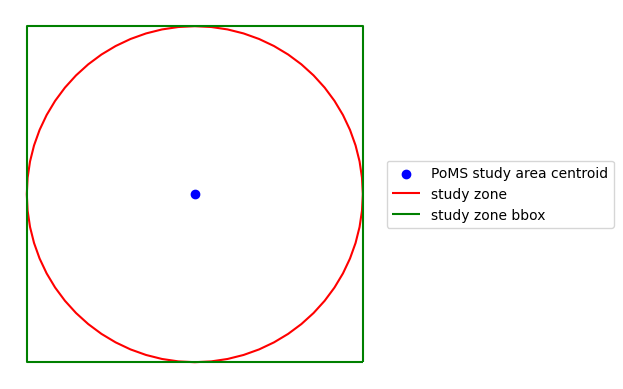

In [78]:
fig, ax = plt.subplots(1, 1)
sample_data.iloc[[0]].plot(ax=ax, color='blue', label='PoMS study area centroid')
sample_data.set_geometry('study_zone').iloc[[0]].exterior.plot(ax=ax, label='study zone', 
                                                               color='red')
sample_data.set_geometry('study_zone_bbox').iloc[[0]].exterior.plot(ax=ax, 
                                                                    label='study zone bbox', 
                                                                    color='green')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axis('off')
plt.show()


That looks good - we have the sample data study centroid in blue, a study zone in red (as would normally be defined as part of a field survey etc.), and the bounding box in green which bounds the study zone.

## Satellite imagery download

### Introduction

This section walks through a simple methodology for downloading Sentinel-2 imagery hosted on AWS [2], making use of PySTAC client [3] which builds on PySTAC [4], a Python library for working with SpatioTemporal Asset Catalog (STAC) [5] data.

This method could be simply adapted to interact with the other data sources in the growing list of resources available at /about/datasets in [5].

The Copernicus Sentinel-2 mission [6] delivers high resolution multispectral imagery (10 - 60 metres depending on the band) with two satellites, at a revisit frequency of 5 days for the vast majority of the Earth's terrestrial surface. Here I'm downloading Level-2A products (surface reflectance orthoimage with atmospheric correction); other processing levels are also available.

### Create local directories

Take the first PoMS location as a demonstration data point. The following process could be repeated for other rows in the sample data, and could be adapted to work with remote or cloud-hosted storage (e.g. AWS S3), both for inputs and outputs.

Start by creating download directories:

In [10]:
demo_datapoint = sample_data.iloc[0]

In [11]:
DOWNLOAD_PATH = '../../../data/Agric_data/test_download/'

def create_zone_dir(dir_name):
    '''Builds local directory structure to download data into and returns target download 
    path.'''
    full_download_path = os.path.join(DOWNLOAD_PATH, dir_name)
    if os.path.exists(full_download_path):
        return full_download_path
    else:
        os.mkdir(full_download_path)
        print('Created data dir at ' + full_download_path)
        return full_download_path

location_code = demo_datapoint['location_code']
aoi_download_path = create_zone_dir(f'aoi_{location_code}')

### Get PyStack client and initiate Rasterio AWS session 

In [12]:
def get_pystack_aws_sessions():
    '''Initiates a pystac client and rasterio AWS session to coordinate requests.'''
    
    # Instantiate a stac client to download the images
    client = Client.open("https://earth-search.aws.element84.com/v1")
    
    # Instantiate an AWS session to download S2 imagery
    aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)

    return client, aws_session

client, aws_session = get_pystack_aws_sessions()

### Search a STAC and filter results

Start by searching a specified STAC with spatial and temporal filtering.

Optionally filter on query logic, which allows source filtering based on properties of the acquisition (see docstring for syntax examples with cloud cover, and processing baseline).

In [13]:
def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic

def conform_bbox(shapely_bbox):
    '''Returns coords as left, bottom, right, top from a shapely box.
    
    This is a utility function to go between shapely and (rasterio and pystac)'''
    shapely_bbox_coords = shapely_bbox.exterior.coords.xy
    rio_stac_bbox_coords = [min(shapely_bbox_coords[0]), # Align shapely and pystac conventions
                             min(shapely_bbox_coords[1]), 
                             max(shapely_bbox_coords[0]), 
                             max(shapely_bbox_coords[1])]
            
    return rio_stac_bbox_coords
    
def search_stac(client, aoi_bbox_geodetic=None, datetime=None, max_items=1000, query=None):
    '''searchs a stac collection with using client, filtering based on aoi_bbox_geodetic
    (a shapely box in EPSG:4326), and based on datetime. See pystac docs for client.search 
    API details.

    Note that pystac client expands datetimes, i.e. from the docs "2017 
    expands to 2017-01-01T00:00:00Z/2017-12-31T23:59:59Z".
    
    query examples:
      filter on processing baseline (see https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline)
        query = {'s2:processing_baseline': {"neq": "05.00"}}

      filter on cloud cloverage
        query=['eo:cloud_cover<50']
    '''
    
    search = client.search(max_items=max_items, # speed up
                           collections=['sentinel-2-l2a'],
                           query=query,
                           bbox=conform_bbox(aoi_bbox_geodetic),
                           datetime=datetime)

    if search.matched() == max_items:
        print('Did not receive complete results. Consider increasing max_items kwarg ' + \
          f'(currently {max_items}).')

    return search

# Create variables for this datapoint's bbox
aoi_bbox = demo_datapoint['study_zone_bbox'] # in projected coords
aoi_bbox_geodetic = get_geodetic_bbox(aoi_bbox, sample_data.crs) # in EPSG:4326

# Get search results
search_results = search_stac(client, aoi_bbox_geodetic=aoi_bbox_geodetic, datetime='2019-04', 
                             max_items=1, query=None)

# Run through the rest of the example with the first result
search_item = search_results.items().__next__()
date_ref = search_item.datetime.strftime('%Y_%m_%d')
search_item

Did not receive complete results. Consider increasing max_items kwarg (currently 1).


<Item id=S2B_30UXB_20190427_0_L2A>

Filter results based on spatial coverage - in this case require that the acquisition completely covers the AOI.

In [14]:
def item_covers_aoi(stac_item, aoi_geodetic):
    '''Returns true/false depending on whether the acquisition geometry fully covers the
    AOI.'''
    return shapely.geometry.shape(stac_item.geometry).contains(aoi_geodetic)

item_covers_aoi(search_item, aoi_bbox_geodetic)
    

True

Now create a function to download results from AWS, and filter on the proportion of cloudy pixels in the S2 scene classification .

In [15]:
def read_S3(href, aoi_bbox_geodetic):
    '''Downloads the data and metadata corresponding to an acquisition, based on a 
    reference and spatial filter (defined as a shapely bbox in EPSG:4326).'''
    with rasterio.open(href) as src:
        # Transform window to src crs
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = shapely.ops.transform(transform_geodetic_to_s2, aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(*conform_bbox(src_bbox),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}

# Get the S2 scene classification map
s2_scl = read_S3(search_item.assets['scl'].href, aoi_bbox_geodetic)

# Filter on clouds
def pass_clouds(scl_data, max_cloud_perc=None):
    '''Returns true/false depending on whether the area proportion of the acquisition which
    is cloudy (according to the S2 cloud detection algorithm) is less than max_cloud_perc.'''
    
    medium_cloud_prob = np.sum(scl_data == 8)
    high_cloud_prob = np.sum(scl_data == 9)

    return (100 * ((medium_cloud_prob + high_cloud_prob) / np.size(scl_data))) < max_cloud_perc
    
max_cloud_perc = 10
pass_clouds(s2_scl['data'], max_cloud_perc=max_cloud_perc)


False

This acquisition doesn't pass the cloud test but let's continue anyway and see what it looks like:

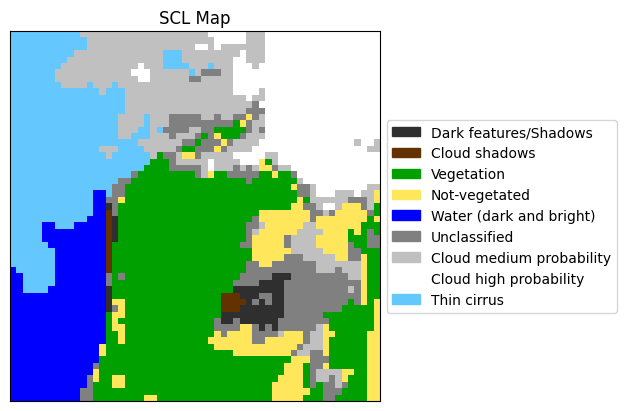

In [28]:
# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']

classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, 
                                                                                        classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)

fig, ax = plt.subplots()
im = ax.imshow(np.squeeze(np.moveaxis(s2_scl['data'], 0, -1)), 
                   norm=scl_norm,
                   cmap=scl_cmap, 
                   interpolation='nearest') # Just for image / display resolution mismatches, does not alter underlying values
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('SCL Map', wrap=True)
cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)

cbar.ax.set_visible(False)
ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Download acquisition data

For desired band names, read data into memory:

In [16]:
band_names = ['red', 'nir', 'visual']

# Download data and metadata into a dictionary with band names as keys
band_data = {band_name: read_S3(search_item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}

# Already calculated scl so just add that to the dictionary
band_data['scl'] = s2_scl

band_data

{'red': {'data': array([[[1172, 1414, 1466, ..., 4064, 3696, 3514],
          [1220, 1394, 1534, ..., 3798, 3540, 3520],
          [1350, 1500, 1578, ..., 3748, 3696, 3794],
          ...,
          [ 360,  409,  450, ..., 2460, 2448, 2532],
          [ 386,  429,  501, ..., 2386, 2436, 2548],
          [ 396,  457,  549, ..., 2286, 2398, 2482]]], dtype=uint16),
  'profile': {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 116, 'height': 116, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 648288.7350929414,
         0.0, -10.0, 5630151.732311958), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}},
 'nir': {'data': array([[[1918, 1720, 1388, ..., 5252, 5072, 5092],
          [1704, 1836, 1482, ..., 4940, 4828, 5036],
          [1836, 1938, 1504, ..., 4900, 4872, 4900],
          ...,
          [ 590,  713,  865, ..., 3540, 3514, 3500],
          [ 658,  796,  957, ..., 3450, 3464, 3514],
          

### Calculate desired indices or composites

For example the normalised difference vegetation index (NDVI):

In [86]:
ndvi = (band_data['nir']['data'].astype(np.float32) - band_data['red']['data'].astype(np.float32)) \
        / (band_data['nir']['data'].astype(np.float32) + band_data['red']['data'].astype(np.float32))

nan_mask = np.logical_or(band_data['nir']['data'] == band_data['nir']['profile']['nodata'], 
                        band_data['red']['data'] == band_data['red']['profile']['nodata'])
ndvi = np.where(~nan_mask, ndvi, np.nan)

ndvi_profile = {**band_data['nir']['profile'].copy(), **{'nodata':np.nan, 'dtype': 'float32'}}
band_data['ndvi'] = {'data': ndvi, 'profile': ndvi_profile}

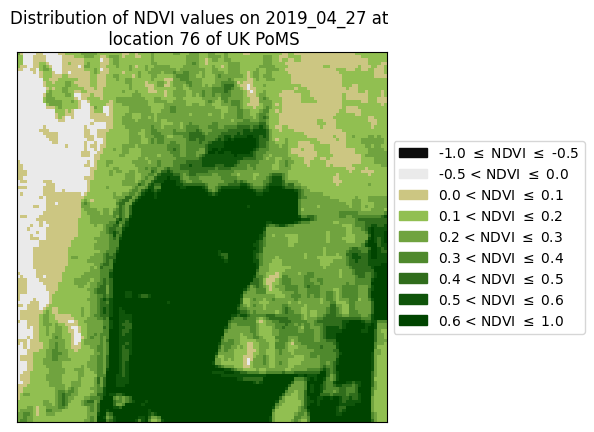

In [87]:
# Colormap as defined at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
ndvi_ranges = ['-1.0 $\leq$ NDVI $\leq$ -0.5',
               '-0.5 < NDVI $\leq$ 0.0',
               '0.0 < NDVI $\leq$ 0.1',
               '0.1 < NDVI $\leq$ 0.2',
               '0.2 < NDVI $\leq$ 0.3',
               '0.3 < NDVI $\leq$ 0.4',
               '0.4 < NDVI $\leq$ 0.5',
               '0.5 < NDVI $\leq$ 0.6',
               '0.6 < NDVI $\leq$ 1.0'
              ]

ndvi_ranges_nums =  [-1.0, -0.5, 0.0,
                                    0.1,
                                    0.2,
                                    0.3,
                                    0.4,
                                    0.5,
                                    0.6,
                                    1.0]
ndvi_colors = [[i/255 for i in [12, 12, 12]],
                        [i/255 for i in [234, 234, 234]],
                        [i/255 for i in [204, 198, 130]],
                        [i/255 for i in [145, 191, 81]],
                        [i/255 for i in [112, 163, 63]],
                        [i/255 for i in [79, 137, 45]],
                        [i/255 for i in [48, 109, 28]],
                        [i/255 for i in [15, 84, 10]],
                        [i/255 for i in [0, 68, 0]]]


ndvi_cmap = mpl.colors.LinearSegmentedColormap.from_list('NDVI map', ndvi_colors, len(ndvi_colors))
ndvi_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(ndvi_colors, ndvi_ranges)]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_ranges_nums, ndvi_cmap.N)

fig, ax = plt.subplots()
im = ax.imshow(ndvi[0,:,:], cmap=ndvi_cmap, norm=ndvi_norm)
cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
cbar.ax.set_visible(False)
ax.legend(handles=ndvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([])
ax.set_yticks([])
plt.title(f'Distribution of NDVI values on {date_ref} at \n location {location_code} of UK PoMS')
plt.show()

### Write to disk

Create download directory for this acquisition date:

In [24]:
aoi_date_download_path = os.path.join(aoi_download_path, date_ref)
if not os.path.exists(aoi_date_download_path):
    os.makedirs(aoi_date_download_path, exist_ok=True)


Write results, reprojecting everything into WORKING_CRS:

In [55]:
def get_reprojected_profile(src_profile, target_crs, target_width=None, target_height=None, target_res=None):
    '''Calculates necessary changes to an arbritary source profile (a dictionary
    based on a rasterio read) to write to a target CRS or target width, height.'''
    transformer = rasterio.transform.AffineTransformer(src_profile['transform']) 
    left, top = transformer.xy(0,0, offset='ul')
    right, bottom = transformer.xy(src_profile['height'], src_profile['width'], offset='ul')
    
    # Get default transform
    transform, width, height = rasterio.warp.calculate_default_transform(src_profile['crs'], 
                                                                            target_crs, 
                                                                            src_profile['width'], 
                                                                            src_profile['height'], 
                                                                            left=left,
                                                                            bottom=bottom,
                                                                            right=right,
                                                                            top=top,
                                                                            dst_width=target_width,
                                                                            dst_height=target_height,
                                                                            dst_resolution=target_res)

    # Update profile with new crs, transform and dimensions
    transform, width, height = rasterio.warp.aligned_target(transform, width, height, target_res)
    new_profile = {k:v for k, v in src_profile.items()}
    new_profile.update({'crs': target_crs,
                        'transform': transform,
                        'width': width,
                        'height': height})

    return new_profile
    

# Write each band, reprojecting on the fly and aligning with a given band spec (here that of the red band)
target_height, target_width = (band_data['red']['profile'][i] for i in ['height', 'width'])
target_res = (-band_data['red']['profile']['transform'][4], band_data['red']['profile']['transform'][0])
reprojected_profile = get_reprojected_profile(band_data['red']['profile'], WORKING_CRS, target_width=target_width, 
                                                  target_height=target_height, target_res=target_res)
for band_name, data_profile in band_data.items():
    full_write_path = os.path.join(aoi_date_download_path, band_name + '.tif')

    # Conform data type and band count
    data  = data_profile['data']
    profile = data_profile['profile']
    reprojected_profile.update({'nodata': profile['nodata'], 'dtype': profile['dtype'], 'count': profile['count']})
    
    with rasterio.open(full_write_path, 'w', **reprojected_profile) as dst:
        for i in range(1, reprojected_profile['count'] + 1):
            rasterio.warp.reproject(source=data,
                                    destination=rasterio.band(dst, i),
                                    src_transform=profile['transform'],
                                    src_crs=profile['crs'],
                                    resampling=rasterio.warp.Resampling.nearest)

## Optionally mask to the AOI bounding box

Often the working CRS used in a study will differ from the CRS used to store the imagery requested, which results in more data being downloaded than is actually required because of the way bounding boxes are rotated on reprojection.

This is often fine for analysis purposes but it's also possible to trim down the result, as follows:

In [68]:
def trim_raster(to_trim_path, geometry):
    '''Overwrites to_trim_path, trimming to (shapely) geometry defined in same CRS as raster.'''
    with rasterio.open(to_trim_path) as src:
        data, masked_transform = rasterio.mask.mask(src, [geometry], crop=True)
        profile = src.profile
        
    profile.update({"height": data.shape[1],
                    "width": data.shape[2],
                    "transform": masked_transform})

    with rasterio.open(to_trim_path, "w", **profile) as dest:
        dest.write(data)

for band_name in band_data.keys():
    trim_raster(os.path.join(aoi_date_download_path, band_name + '.tif'), aoi_bbox)

## Results

That's it! We have S2 crops plus any additional processing (here NDVI) for a specific AOI and date. The functions defined here are simple to loop / parallelise to handle multiple AOIs and dates.

Looking at the results, we have the visual, SCL, NDVI, and NDVI input bands clipped to the AOI geometry in the working spatial reference system, with the study area in red (bbox, study geom and centroid on the visual):

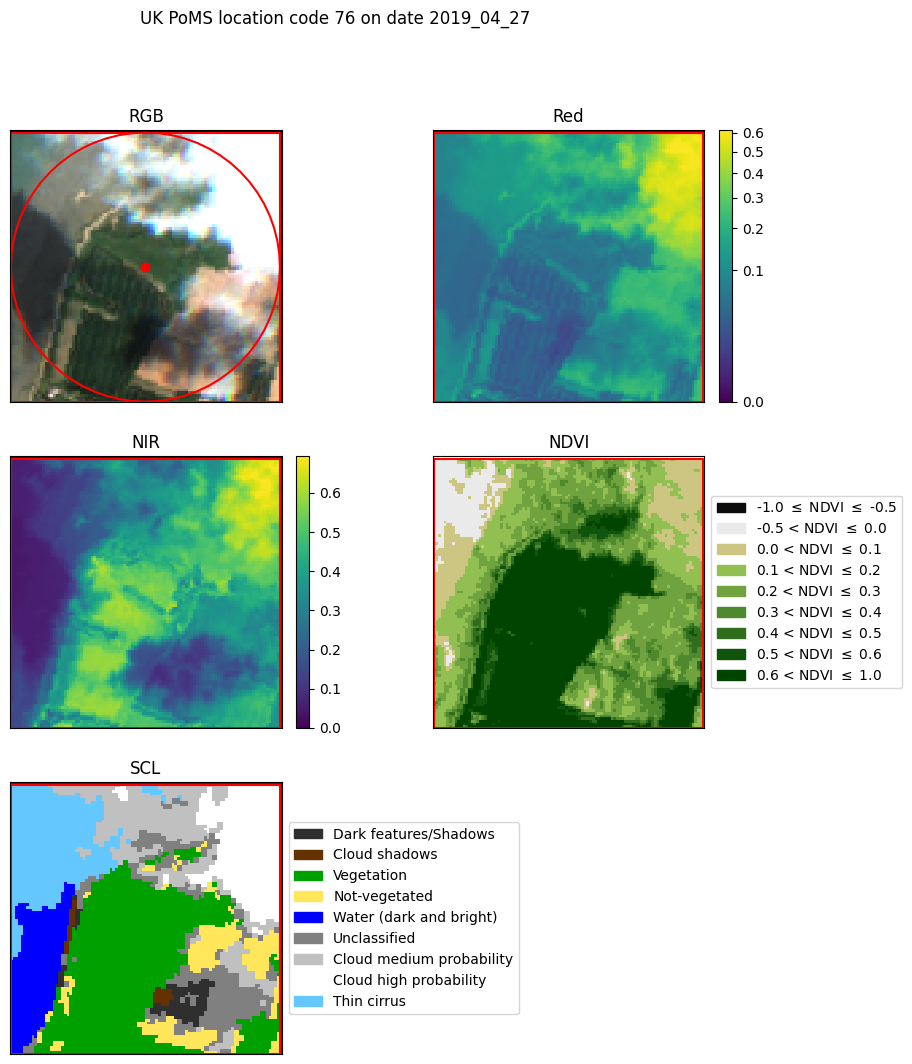

In [69]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12))
axs = axs.ravel()

views = ['visual', 'red', 'nir', 'ndvi', 'scl']
titles = ['RGB', 'Red', 'NIR', 'NDVI', 'SCL']
norms = [None, mpl.colors.PowerNorm(0.4), None, ndvi_norm, scl_norm]
cmaps = [None, None, None, ndvi_cmap, scl_cmap]

for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(aoi_date_download_path, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
        extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   extent=extent
                  )

    if view == 'visual':
        sample_data.iloc[[0]].plot(ax=ax, color='red', label='PoMS study area centroid')
        sample_data.set_geometry('study_zone').iloc[[0]].exterior.plot(ax=ax, label='study zone', 
                                                               color='red')
    sample_data.set_geometry('study_zone_bbox').iloc[[0]].exterior.plot(ax=ax, 
                                                                label='study zone bbox', 
                                                                color='red')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
    elif view == 'ndvi':
        cbar.ax.set_visible(False)
        ax.legend(handles=ndvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.suptitle(f'UK PoMS location code {location_code} on date {date_ref}')
axs[-1].set_axis_off()
plt.show()

## References

1. UK Pollinator Monitoring Scheme (2022). Pan-trap survey data from the UK Pollinator Monitoring Scheme, 2017-2020 version 2 NERC EDS Environmental Information Data Centre. https://doi.org/10.5285/2c43ba3c-d821-442c-989b-754451d72091. [Accessed 16/02/2024].
2. Sentinel-2 Cloud-Optimized GeoTIFFs. https://registry.opendata.aws/sentinel-2-l2a-cogs. [Accessed 20/03/2024].
3. PySTAC Client. https://pystac-client.readthedocs.io/en/stable/#. 
4. PySTAC. https://pystac.readthedocs.io/en/stable/.
5. STAC. https://stacspec.org/en/.
6. Drusch M, Del Bello U, Carlier S, Colin O, Fernandez V, Gascon F, Hoersch B, Isola C, Laberinti P, Martimort P, Meygret A, Spoto F, Sy O, Marchese F, Bargellini P,. Sentinel-2: ESA's Optical High-Resolution Mission for GMES Operational Services. Remote Sensing of Environment.  2012; 120(): 25-36. https://doi.org/10.1016/j.rse.2011.11.026.